# Image Segmentation

## Overview

### Learning Objectives

* Gain familiarity with the different categories of segmentation methods available in ITK
* Understand the difference between region growing methods and how their parameters change their behavior
* Understand the influence of terms in level set segmentation methods

### ITK Segmentation Method Categories

![Segmentation categories](data/segmentation-categories.png)

### Region Growing Methods

The basic approach of a *region growing algorithm* is to **start from a seed region (typically one or more
pixels)** that are considered to be inside the object to be segmented. The **pixels neighboring this
region are evaluated to determine if they should also be considered part of the object**. If so, **they are
added to the region and the process continues as long as new pixels are added to the region**. Region
growing algorithms vary depending on the criteria used to decide whether a pixel should be included
in the region or not, the type connectivity used to determine neighbors, and the strategy used to visit
neighboring pixels.

Example region growing methods available in ITK:

- ConfidenceConnected
- ConnectedThreshold
- IsolatedConnected

#### Confidence Connected

![Confidence Connected](data/confidence-connected.png)

#### Connected Threshold

![Connected Threshold](data/connected-threshold.png)

#### Isolated Connected

![Isolated Connected](data/isolated-connected.png)

### Level Set Segmentation Methods

### Level Set Concept

![Level set concept](data/level-set-concept.png)



#### Level Set Evolution

![Level Set evolution](data/level-set-evolution.png)

#### Level Set Function

$\phi_{t} = - \alpha  \mathbf{A}(\mathbf{x})\cdot\nabla\phi - \beta   P(\mathbf{x})\mid\nabla\phi\mid + \gamma Z(\mathbf{x})\kappa\mid\nabla\phi\mid$

- $\mathbf{A}(\mathbf{x})$: **Advection**
- $P(\mathbf{x})$: **Propagation**
- $Z(\mathbf{x})$: **Spatial modifier for the mean curvature $\kappa$**
- $\alpha, \beta, \gamma$ are scalar constants

- Track the evolution of contours and surfaces by computing the update to the solution $\phi$ of the PDE
- Contour (initial solution) is initialized by the user
- Evolve $\phi$ until
  - It fits the form of the segment you are trying to fit (shape detection)
  - It segments the features you want (segmentation)
- Evolution is uni-directional (inwards or outwards)

For more information, see:

- The [*Segmentation* chapter](https://itk.org/ITKSoftwareGuide/html/Book2/ITKSoftwareGuide-Book2ch4.html#x37-1770004) of Book 2 of the ITK Software Guide, including the sections on [*Region Growing*](https://itk.org/ITKSoftwareGuide/html/Book2/ITKSoftwareGuide-Book2ch4.html#x37-1780004.1) and [*Level Set Segmentation*](https://itk.org/ITKSoftwareGuide/html/Book2/ITKSoftwareGuide-Book2ch4.html#x37-1890004.3).

## Tutorial

In [1]:
import itk

from packaging.version import parse
from importlib.metadata import version

if parse(version('itk')) < parse('5.3'):
    raise ValueError("ITK greater than version 5.3.0 is required for this notebook")

import numpy as np
from itkwidgets import view
from matplotlib import pyplot as plt

%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interactive

#### itk.ConfidenceConnectedImageFilter

From [itk::ConfidenceConnectedImageFilter documentation](https://itk.org/Doxygen/html/classitk_1_1ConfidenceConnectedImageFilter.html):

> Segment pixels with similar statistics using connectivity.

> This filter extracts a connected set of pixels whose pixel intensities are consistent with the pixel statistics of a seed point. The mean and variance across a neighborhood (8-connected, 26-connected, etc.) are calculated for a seed point. Then pixels connected to this seed point whose values are within the confidence interval for the seed point are grouped. The width of the confidence interval is controlled by the "Multiplier" variable (the confidence interval is the mean plus or minus the "Multiplier" times the standard deviation). If the intensity variations across a segment were gaussian, a "Multiplier" setting of 2.5 would define a confidence interval wide enough to capture 99% of samples in the segment.

> After this initial segmentation is calculated, the mean and variance are re-calculated. All the pixels in the previous segmentation are used to calculate the mean the standard deviation (as opposed to using the pixels in the neighborhood of the seed point). The segmentation is then recalculated using these refined estimates for the mean and variance of the pixel values. This process is repeated for the specified number of iterations. Setting the "NumberOfIterations" to zero stops the algorithm after the initial segmentation from the seed point.

In [2]:
# Also observe the help with the Python `help` function
input_image = itk.imread("data/BrainProtonDensitySlice.png", itk.ctype("unsigned char"))
confidence_connected = itk.ConfidenceConnectedImageFilter.New(input_image)
help(confidence_connected)

Help on itkConfidenceConnectedImageFilterIUC2IUC2 in module itk.itkConfidenceConnectedImageFilterPython object:

class itkConfidenceConnectedImageFilterIUC2IUC2(itk.itkImageToImageFilterAPython.itkImageToImageFilterIUC2IUC2)
 |  itkConfidenceConnectedImageFilterIUC2IUC2(*args, **kwargs)
 |  
 |  Proxy of C++ itkConfidenceConnectedImageFilterIUC2IUC2 class.
 |  
 |  Method resolution order:
 |      itkConfidenceConnectedImageFilterIUC2IUC2
 |      itk.itkImageToImageFilterAPython.itkImageToImageFilterIUC2IUC2
 |      itk.itkImageSourcePython.itkImageSourceIUC2
 |      itk.ITKCommonBasePython.itkProcessObject
 |      itk.ITKCommonBasePython.itkObject
 |      itk.ITKCommonBasePython.itkLightObject
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  AddSeed = itkConfidenceConnectedImageFilterIUC2IUC2_AddSeed(...)
 |      AddSeed(self, seed)
 |      
 |      Parameters
 |      ----------
 |      seed: itkIndex2 const &
 |  
 |  ClearSeeds = itkConfidenceConnectedImageFilterIUC2I

In [3]:
# Or, observe the help with IPython `?` operator
confidence_connected?

Signature:      confidence_connected(*args, **kargs)
Type:           itkConfidenceConnectedImageFilterIUC2IUC2
String form:   
ConfidenceConnectedImageFilter (0x55a6aa060d40)
           RTTI typeinfo:   itk::ConfidenceConnectedImageF <...> ialNeighborhoodRadius: 1
           Mean of the connected region: 0
           Variance of the connected region: 0
           
Length:         1
File:           ~/bin/micromamba/envs/itk-course/lib/python3.11/site-packages/itk/itkConfidenceConnectedImageFilterPython.py
Docstring:      Proxy of C++ itkConfidenceConnectedImageFilterIUC2IUC2 class.
Call docstring:
Deprecated procedural interface function.

Use snake case function instead. This function is now
merely a wrapper around the snake case function.

Create a process object, update with the inputs and
attributes, and return the result.

The syntax is the same as the one used in New().
UpdateLargestPossibleRegion() is ran once the input are changed, and
the current output, or tuple of outputs, if

In [4]:
# Set confidence connected filter parameters
confidence_connected.SetMultiplier(2.3)
confidence_connected.SetNumberOfIterations(5)
confidence_connected.SetInitialNeighborhoodRadius(3)
confidence_connected.SetReplaceValue(255)

In [5]:
# What is the *Multiplier*?
confidence_connected.SetMultiplier?

Docstring:
SetMultiplier(self, _arg)

Parameters
----------
_arg: double const
Type:      method


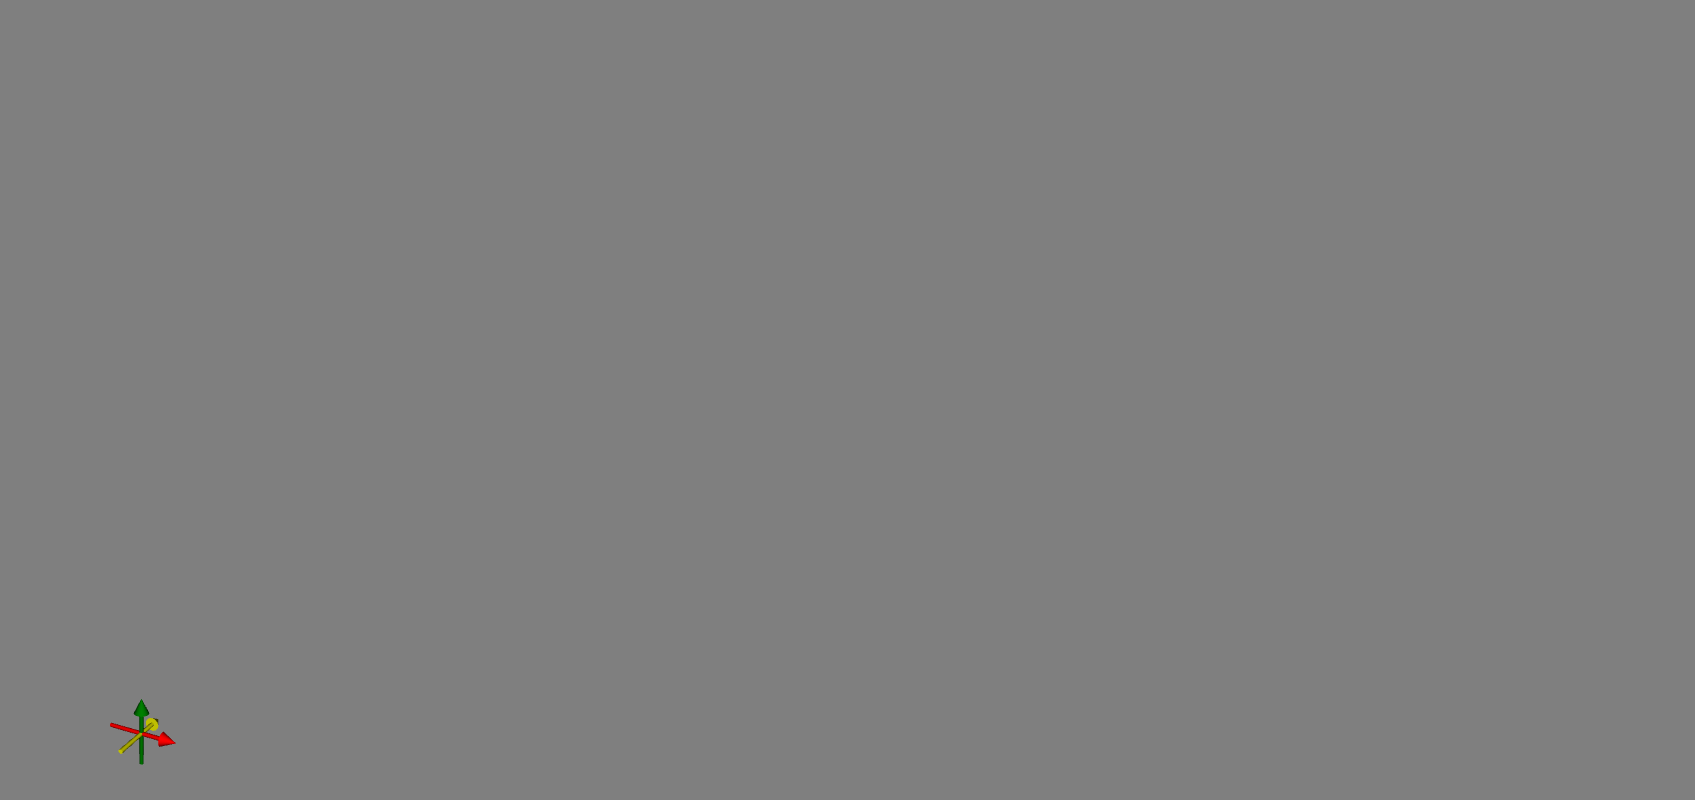
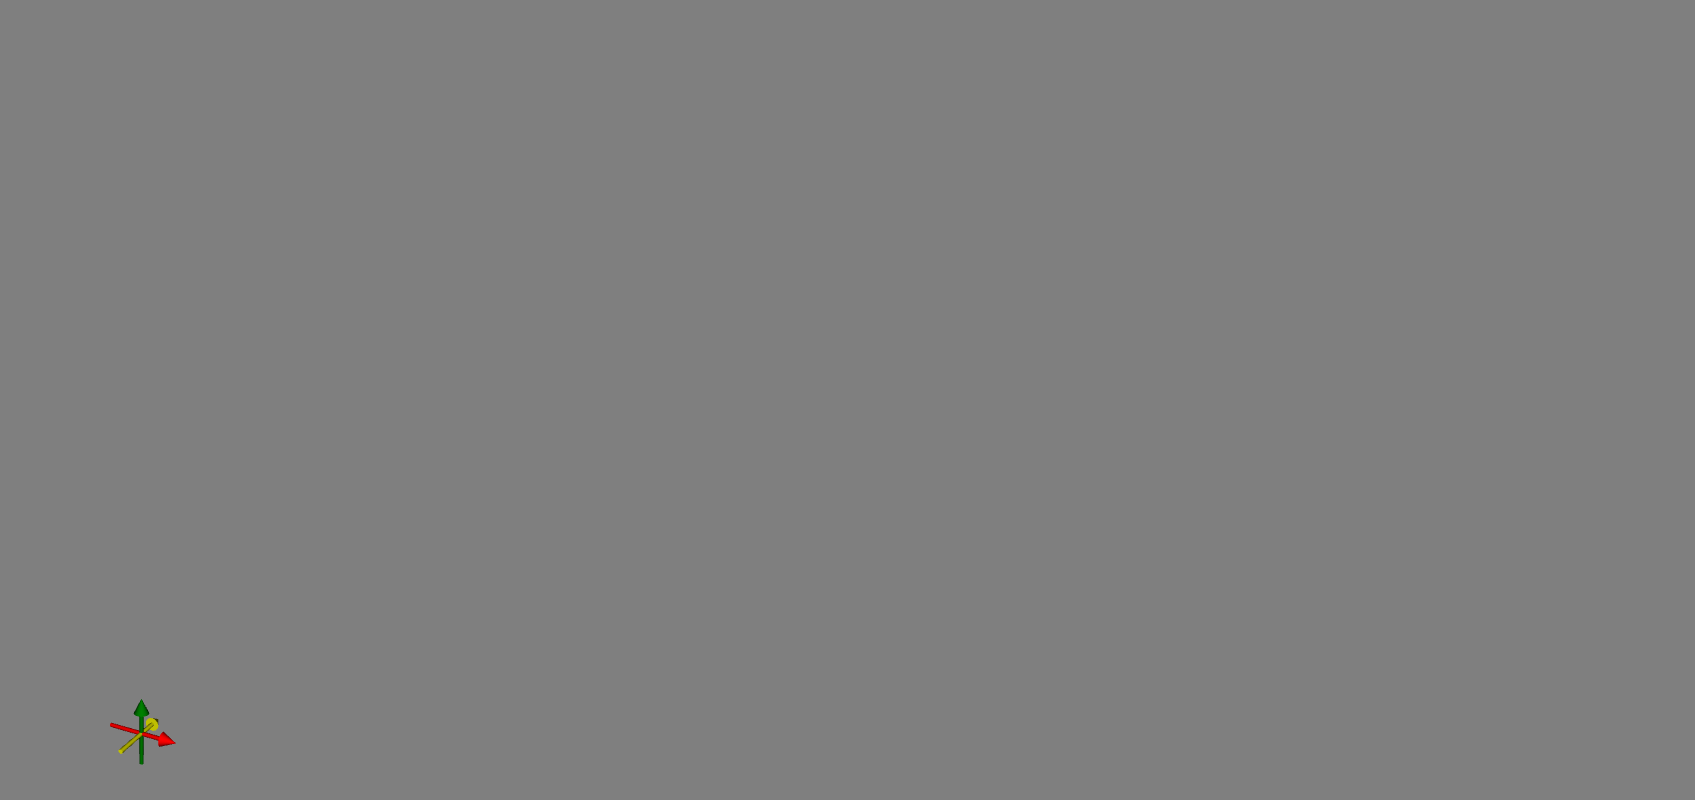

<IPython.core.display.Javascript object>

In [6]:
# View the input image
view(input_image)

In [7]:
# Set the seed points
confidence_connected.SetSeed([100, 110])
confidence_connected.Update()


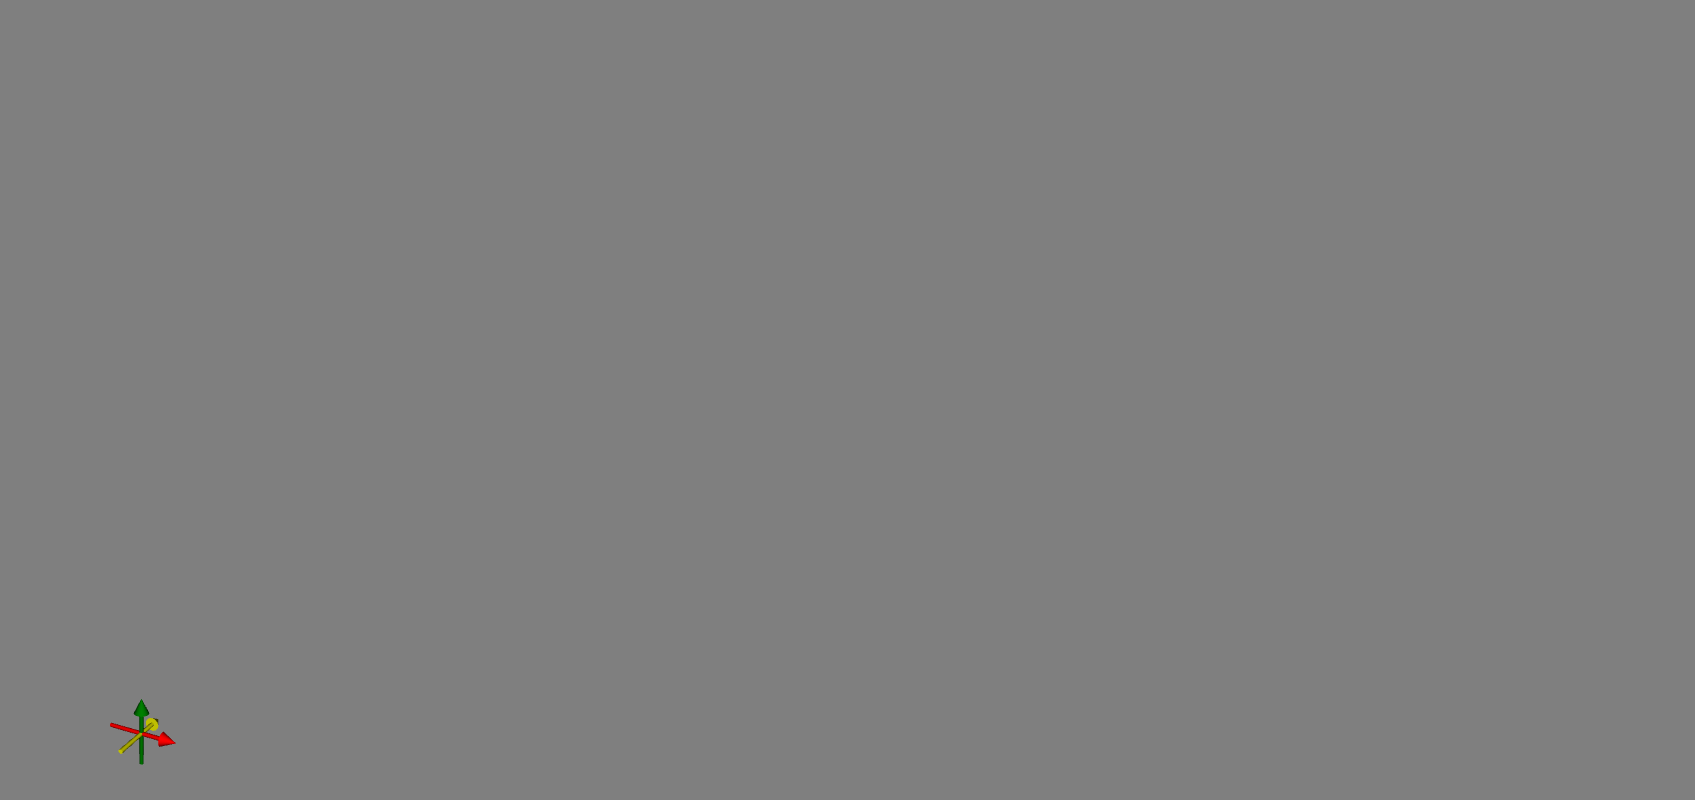
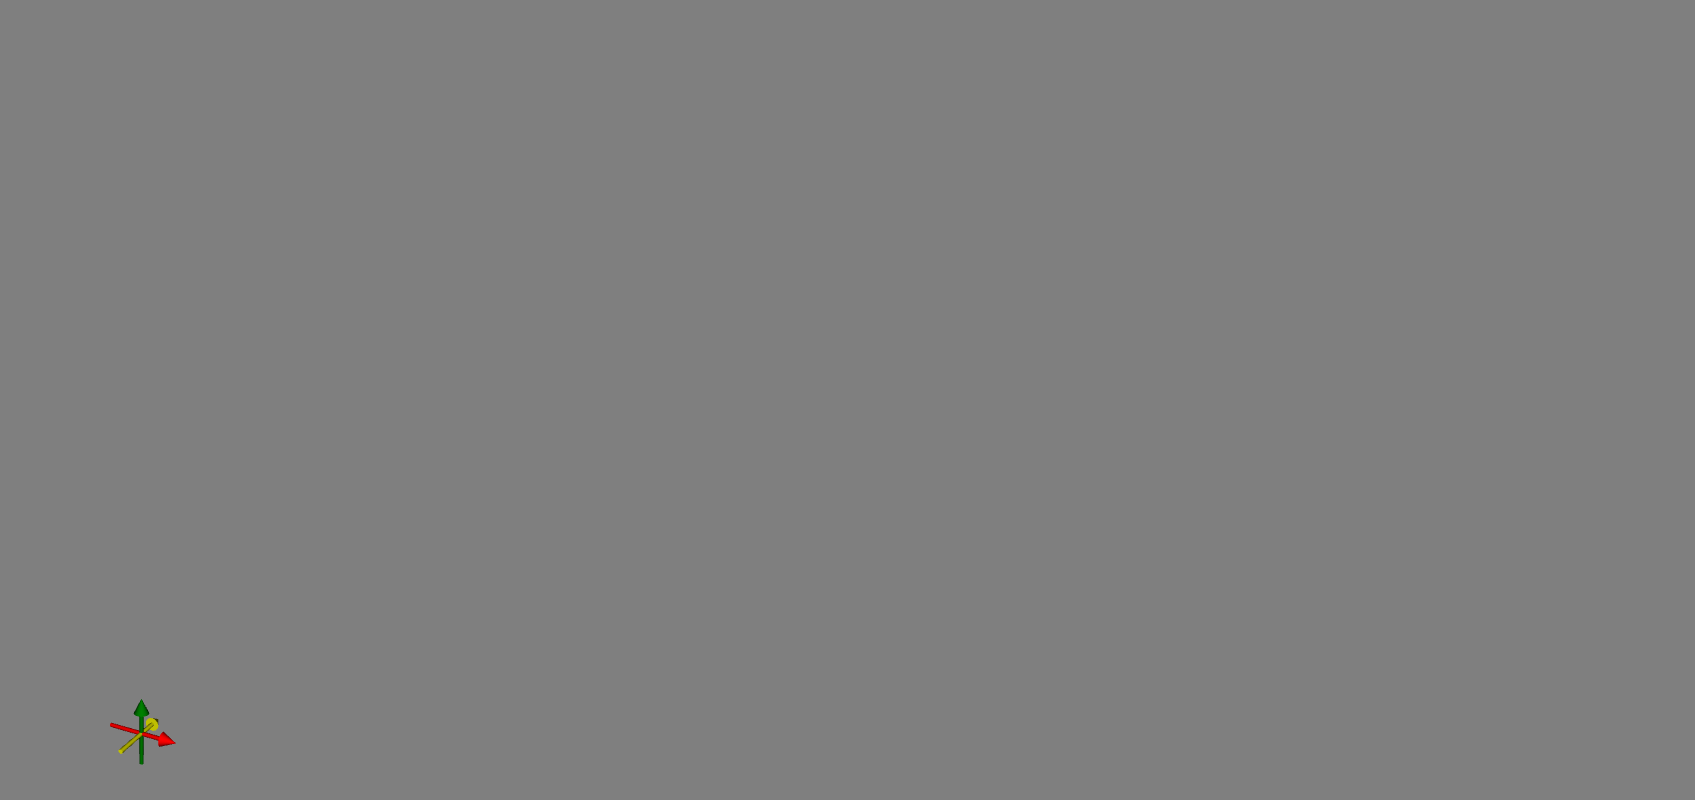

<IPython.core.display.Javascript object>

In [8]:
view(confidence_connected.GetOutput())


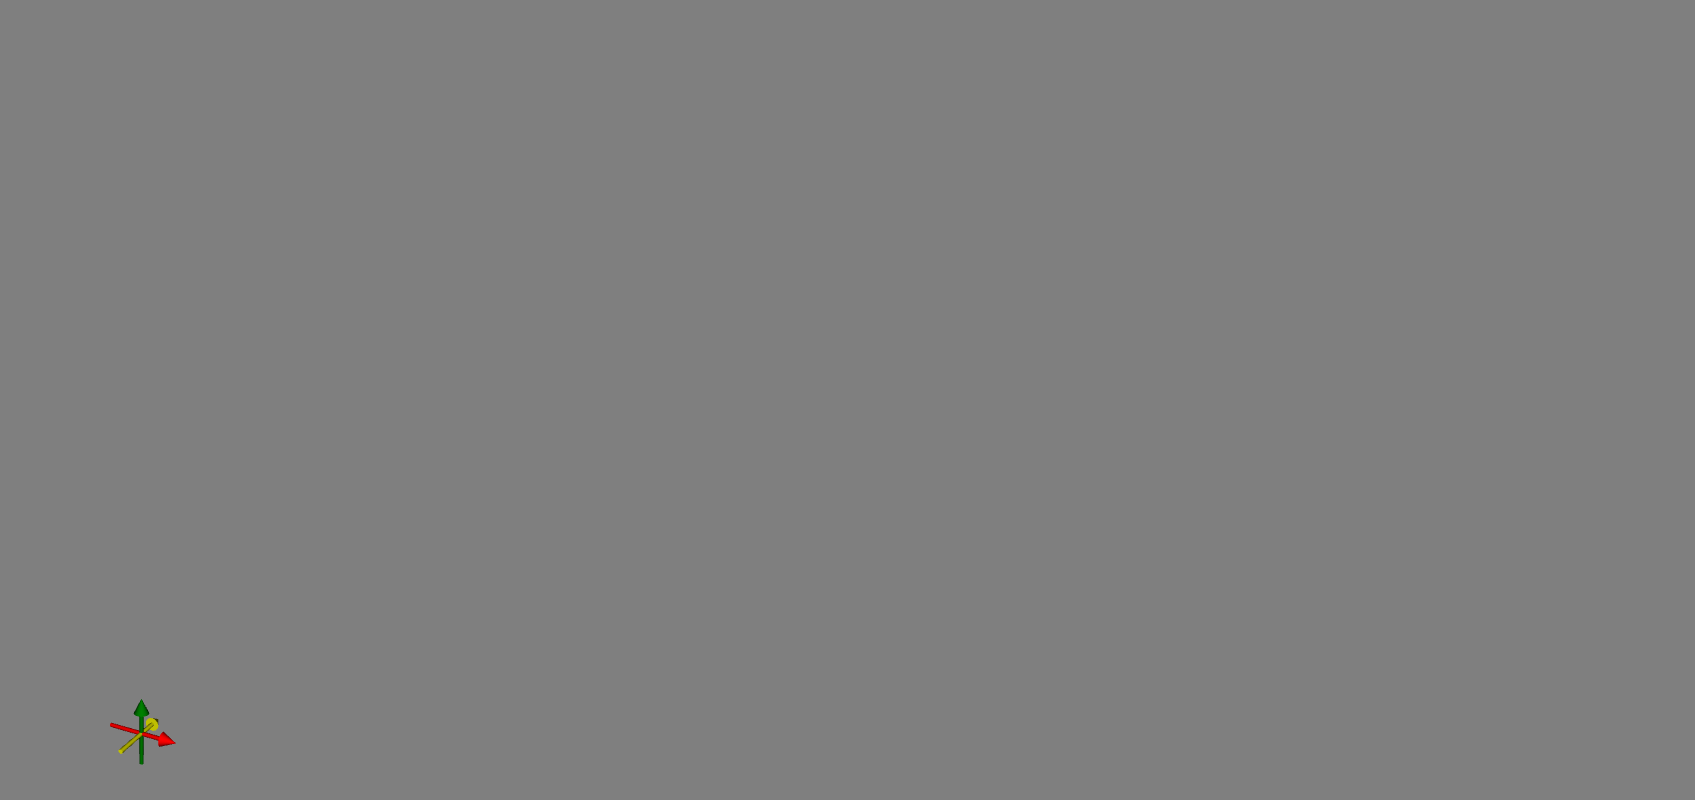
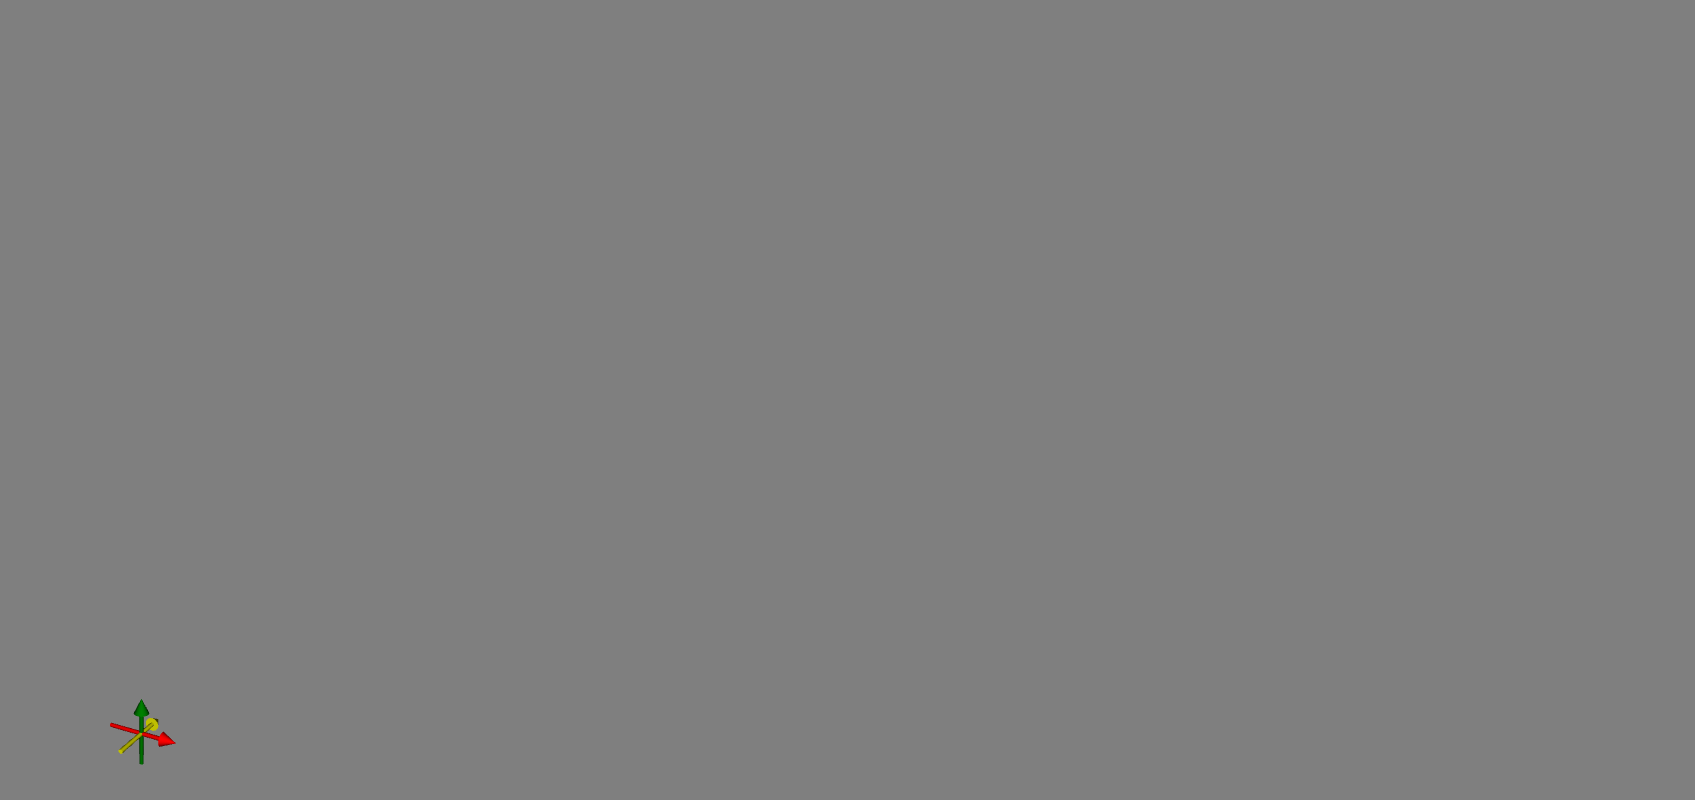

<IPython.core.display.Javascript object>

In [9]:
# Pre-process to improve the result
median_filtered_image = itk.median_image_filter(input_image, radius=1)

confidence_connected_image = itk.confidence_connected_image_filter(
    median_filtered_image,
    seed=[100, 110],
    replace_value=255,
    multiplier=3.0,
    number_of_iterations=5,
    initial_neighborhood_radius=3,
)

view(confidence_connected_image)

#### Fast Marching Segmentation

When the differential equation governing the level set evolution has a very simple form, a fast evolution algorithm called fast marching can be used.

Front propagation: $\Delta x = V \Delta t$

![Fast marching speed image](data/fast-marching-speed-image.png)

#### Fast Marching Time Crossing

![Fast marching time crossing](data/fast-marching-time-crossing.png)

First, let's smooth the input.

In [10]:
# What image types are supported by our smoothing filter?
itk.CurvatureAnisotropicDiffusionImageFilter.GetTypes()

<itkTemplate itk::CurvatureAnisotropicDiffusionImageFilter>
Options:
  [<class 'itk.itkImagePython.itkImageD2'>, <class 'itk.itkImagePython.itkImageD2'>]
  [<class 'itk.itkImagePython.itkImageD3'>, <class 'itk.itkImagePython.itkImageD3'>]
  [<class 'itk.itkImagePython.itkImageD4'>, <class 'itk.itkImagePython.itkImageD4'>]
  [<class 'itk.itkImagePython.itkImageF2'>, <class 'itk.itkImagePython.itkImageF2'>]
  [<class 'itk.itkImagePython.itkImageF3'>, <class 'itk.itkImagePython.itkImageF3'>]
  [<class 'itk.itkImagePython.itkImageF4'>, <class 'itk.itkImagePython.itkImageF4'>]


In [11]:
# Cast to the supported image type
Dimension = input_image.GetImageDimension()
FloatImageType = itk.Image[itk.ctype("float"), Dimension]
caster = itk.CastImageFilter[input_image, FloatImageType].New()
caster.SetInput(input_image)


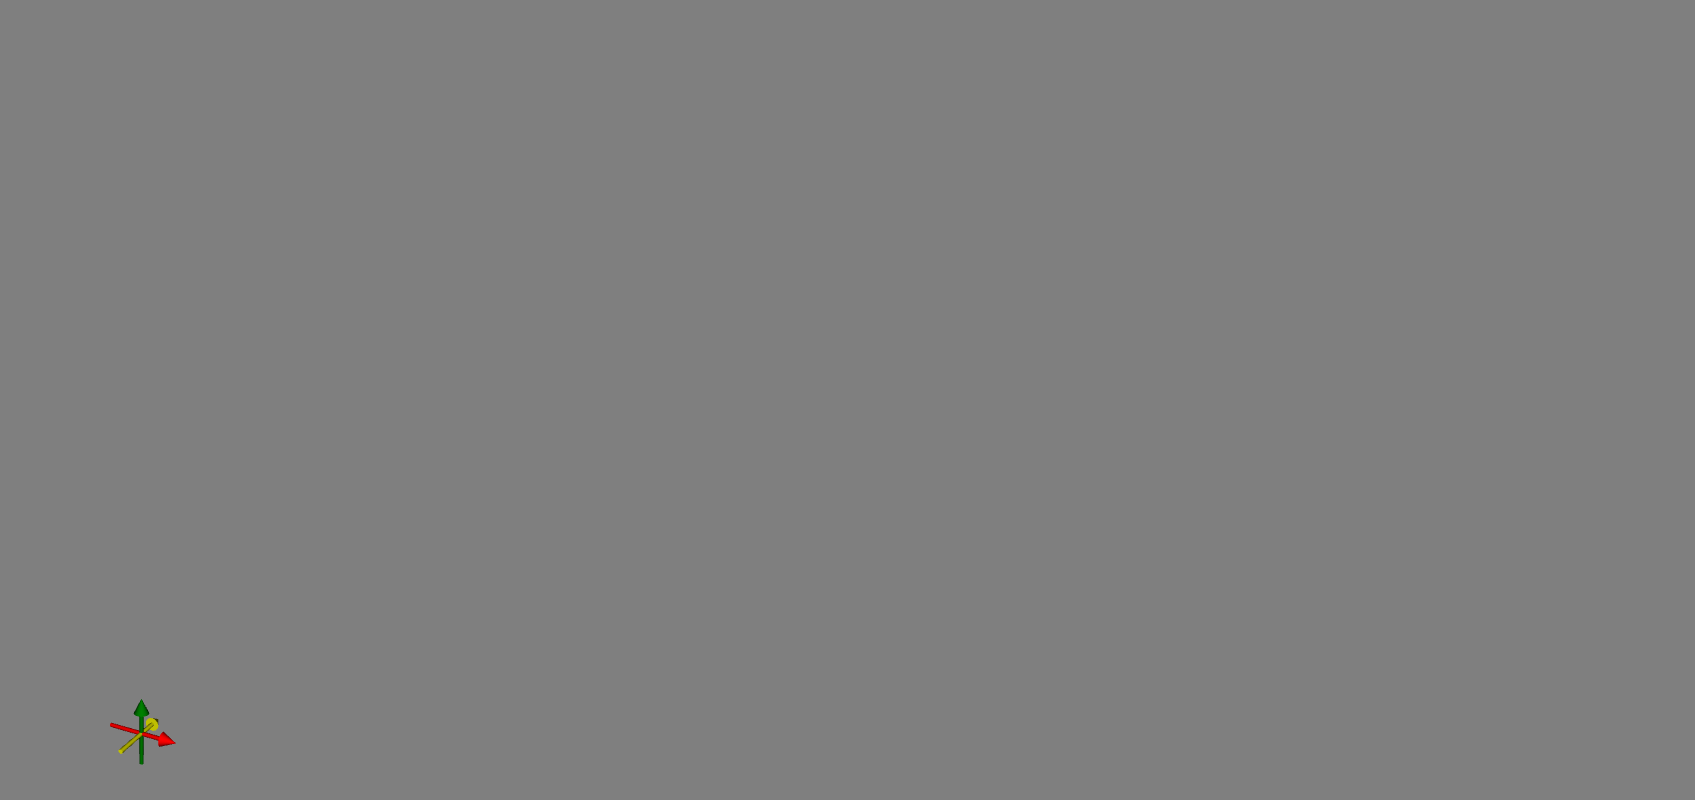
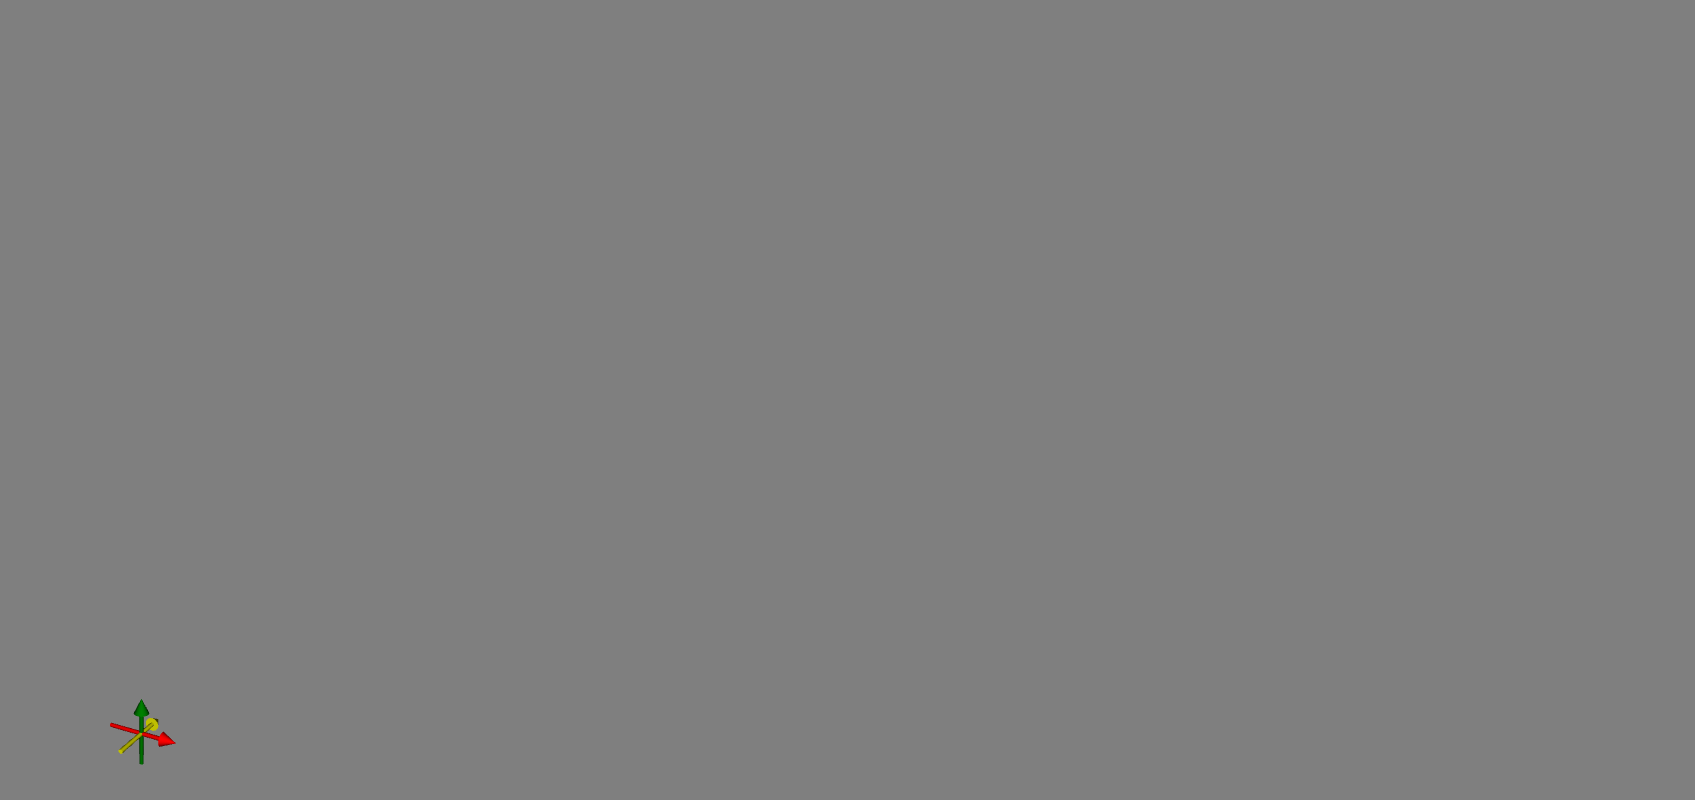

<IPython.core.display.Javascript object>

In [12]:
smoothed_image = itk.curvature_anisotropic_diffusion_image_filter(
    caster, time_step=0.125, number_of_iterations=5, conductance_parameter=3.0
)

view(smoothed_image)

Our speed image will be based off the local gradient magnitude.


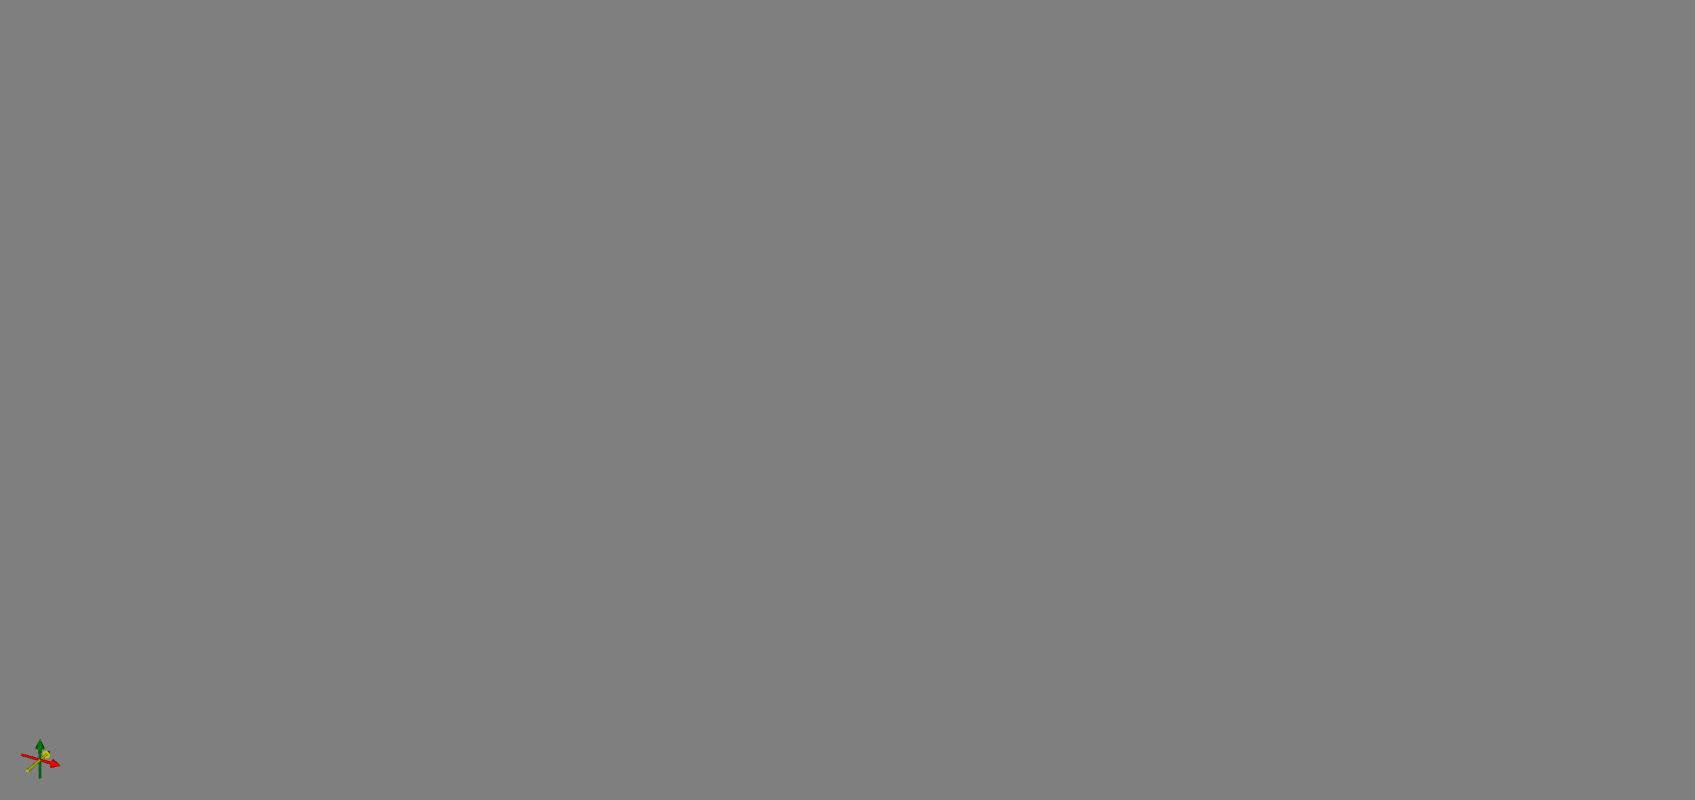
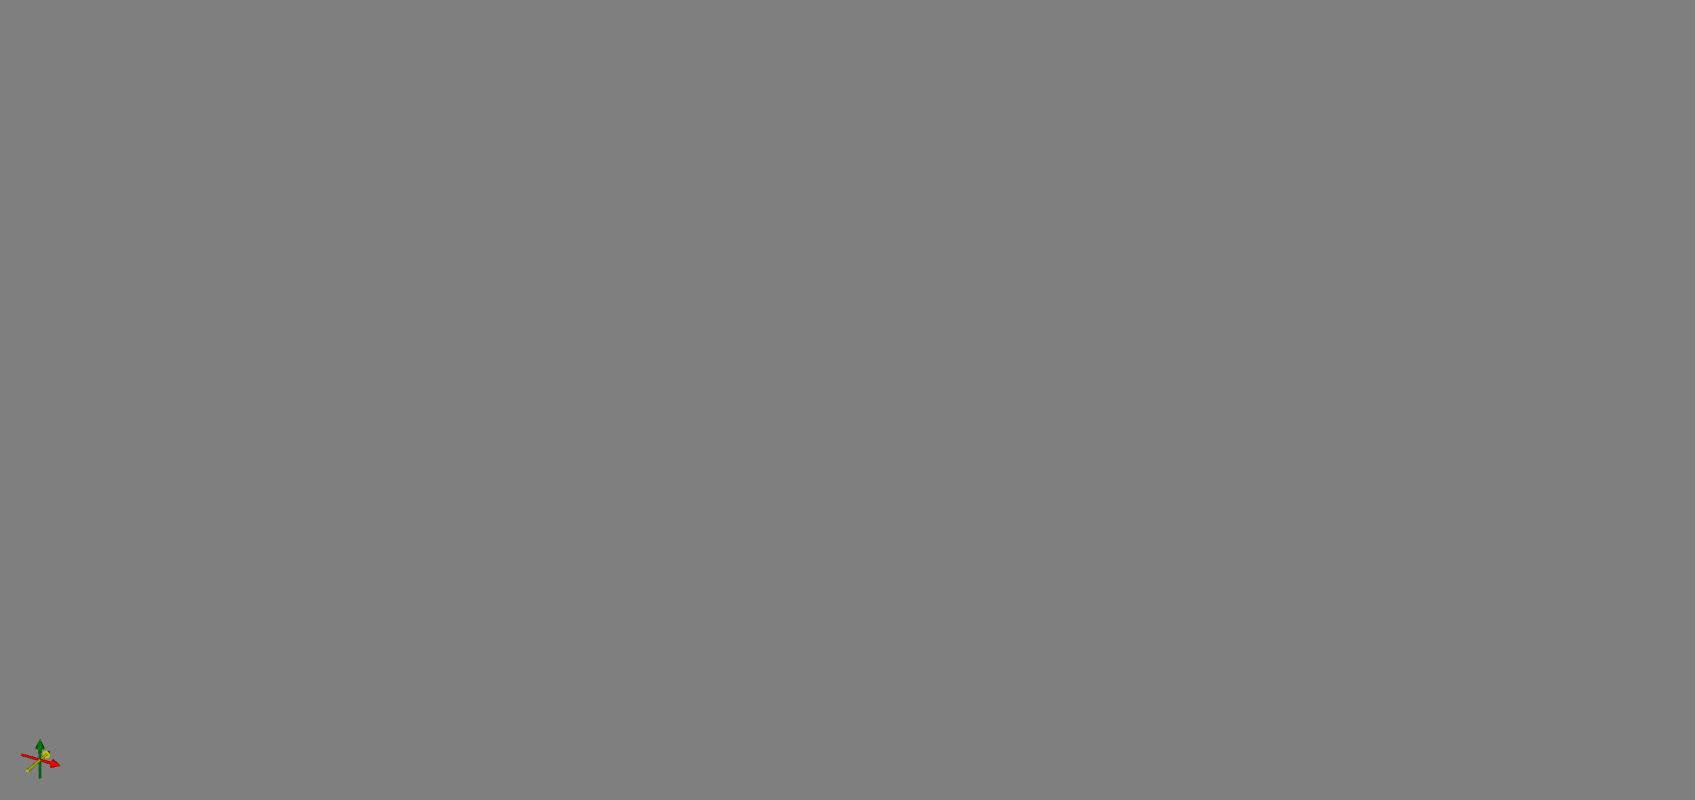

<IPython.core.display.Javascript object>

In [13]:
gradient = itk.gradient_magnitude_recursive_gaussian_image_filter(
    smoothed_image, sigma=1.0
)
view(gradient)

For more information on the strategy for sigmoid parameter selection, see the [itk::SigmoidImageFilter documentation](https://itk.org/Doxygen/html/classitk_1_1SigmoidImageFilter.html) and the [discussion of the FastMarchingImageFilter in the ITK Software Guide](https://itk.org/ITKSoftwareGuide/html/Book2/ITKSoftwareGuide-Book2ch4.html#x37-1890004.3).


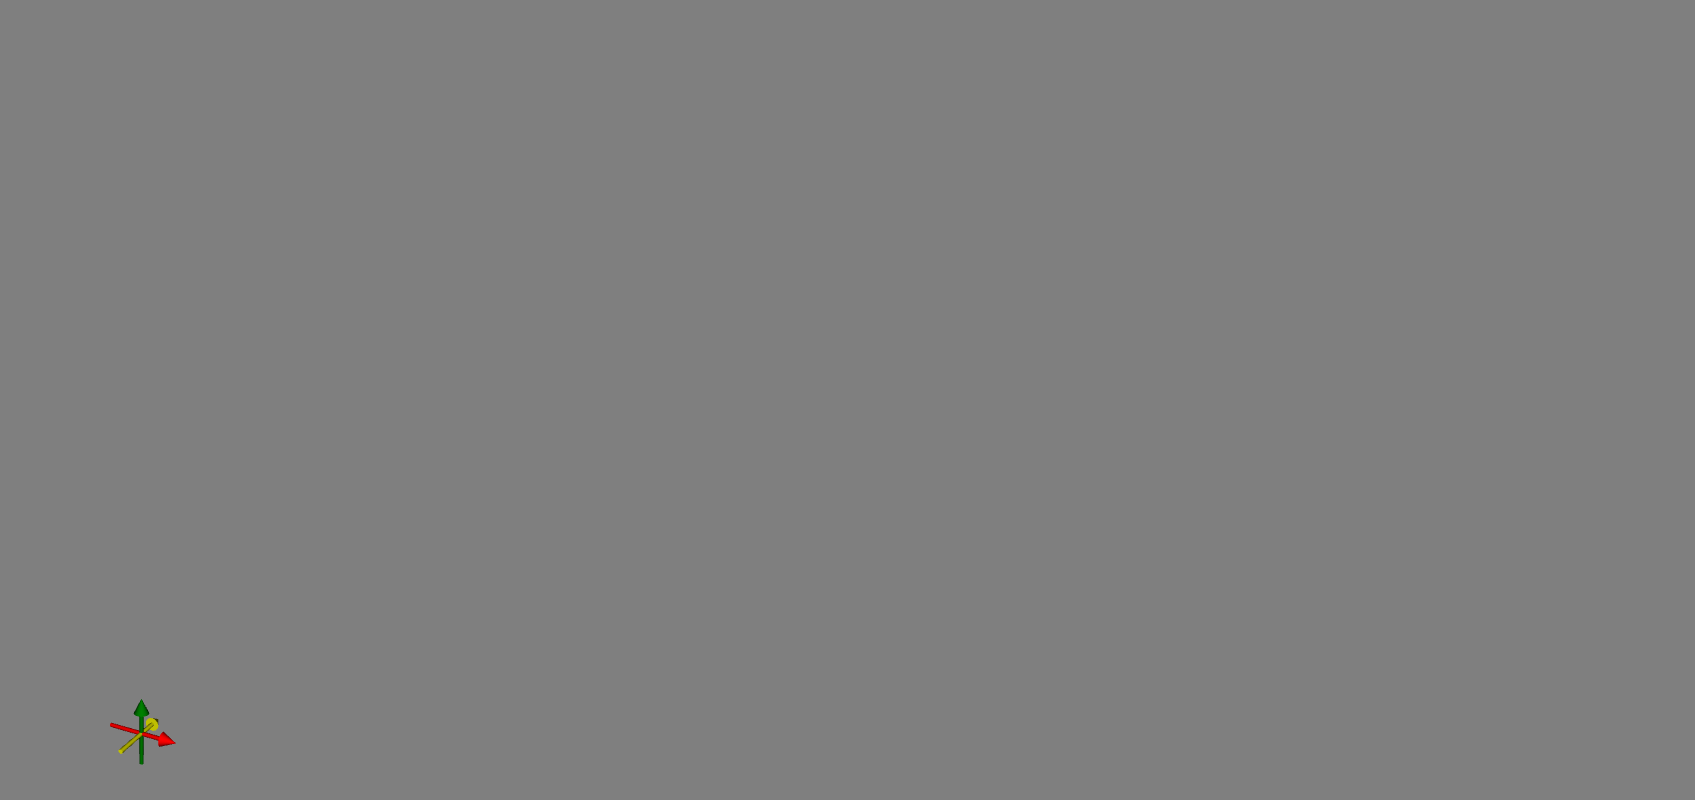
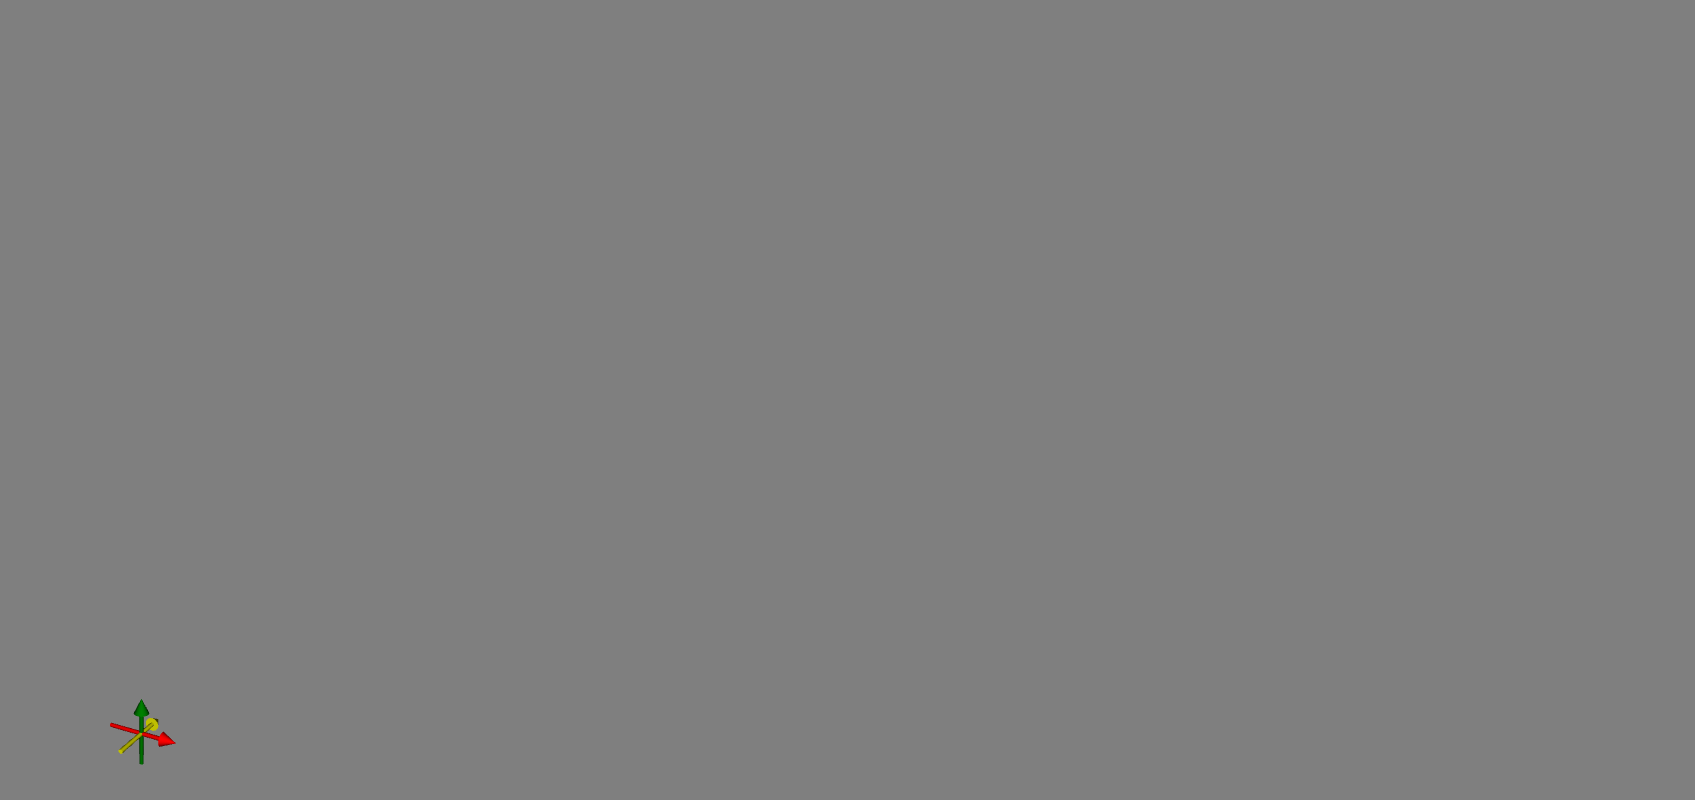

<IPython.core.display.Javascript object>

In [14]:
basin_minimum = 2.25
border_minimum = 3.75

alpha = -(border_minimum - basin_minimum) / 3.0
beta = (border_minimum + basin_minimum) / 2.0

sigmoid = itk.sigmoid_image_filter(
    gradient, output_minimum=0.0, output_maximum=1.0, alpha=alpha, beta=beta
)
view(sigmoid)

In [15]:
fast_marching = itk.FastMarchingImageFilter.New(sigmoid)

seed_value = 0.0
NodeType = itk.LevelSetNode[itk.ctype("float"), Dimension]
node = NodeType()
node.SetIndex([100, 110])
node.SetValue(seed_value)

NodeContainerType = itk.VectorContainer[itk.ctype("unsigned int"), NodeType]
nodes = NodeContainerType.New()
nodes.Initialize()
nodes.InsertElement(0, node)

In [16]:
fast_marching_image = itk.fast_marching_image_filter(
    sigmoid, trial_points=nodes, stopping_value=400.0
)


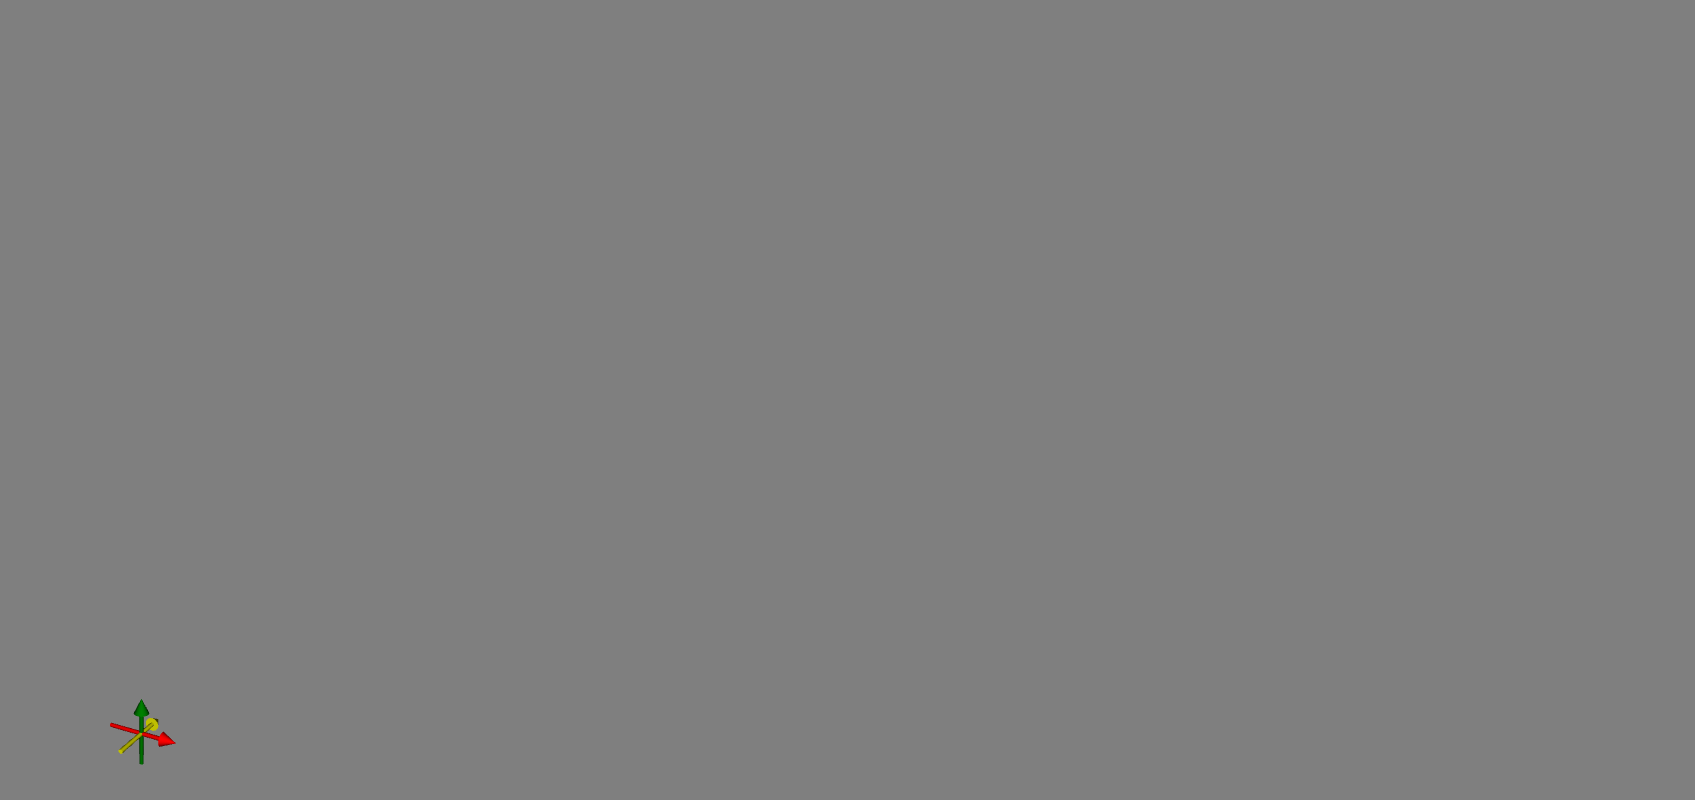
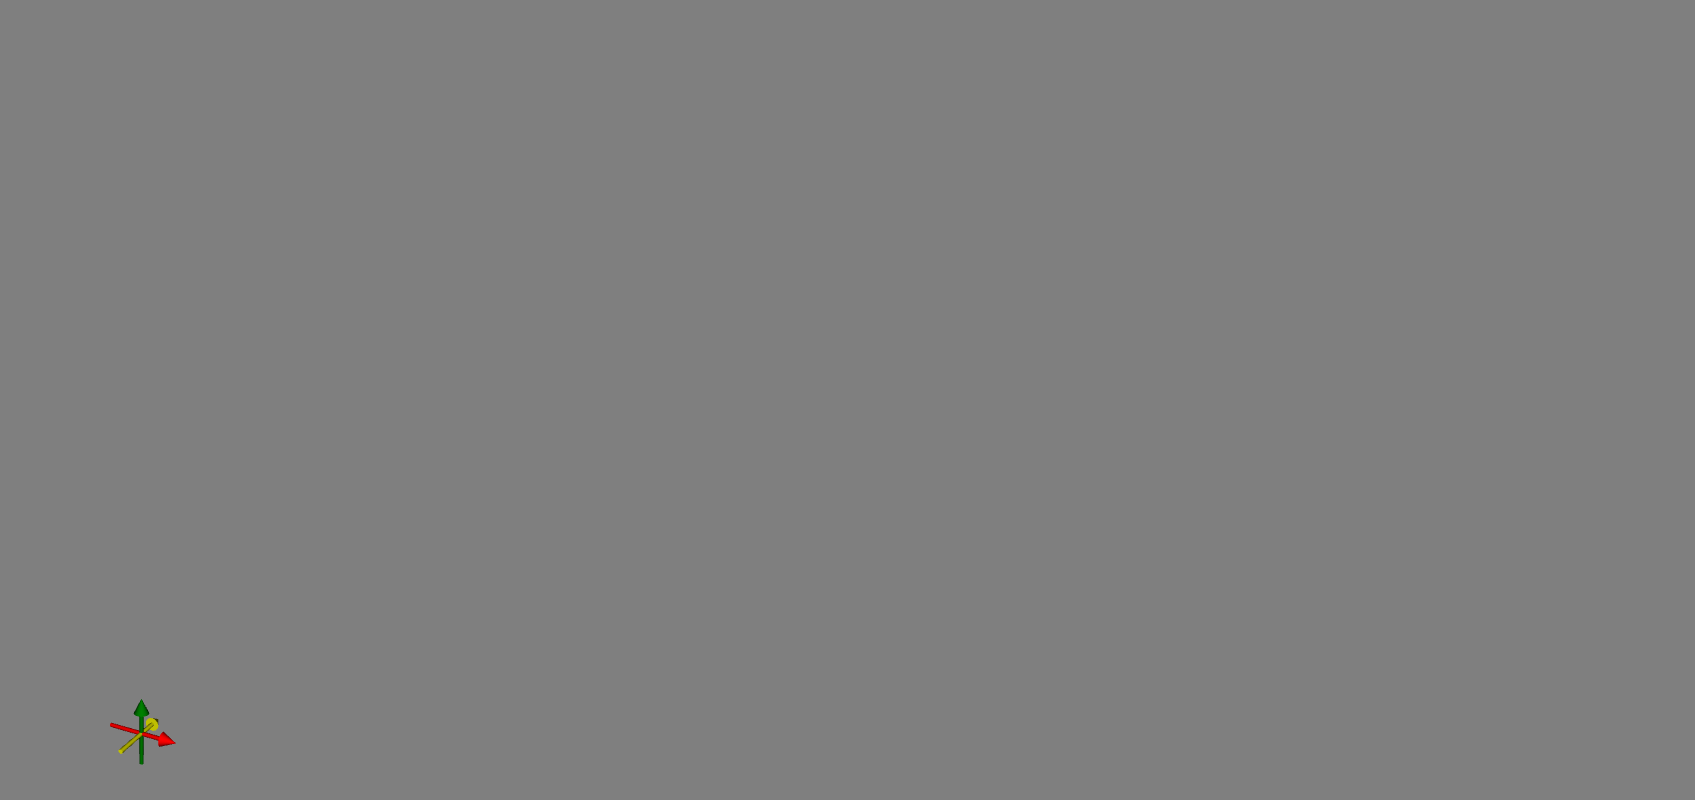

<IPython.core.display.Javascript object>

In [17]:
time_threshold = 100
thresholded_image = itk.binary_threshold_image_filter(
    fast_marching_image,
    lower_threshold=0,
    upper_threshold=time_threshold,
    outside_value=0,
    inside_value=255,
)
viewer = view(thresholded_image, ui_collapsed=True)

In [18]:
time_threshold = 100


def show_thresholded(time_threshold=100.0):
    thresholded_image = itk.binary_threshold_image_filter(
        fast_marching_image,
        lower_threshold=0,
        upper_threshold=time_threshold,
        outside_value=0,
        inside_value=255,
    )
    # NOTE: viewer is taken from the global scope for this function
    global viewer
    viewer.image = thresholded_image


slider = interactive(show_thresholded, time_threshold=(1.0, 400.0, 10.0))

In [19]:
# VBOX interactive windows do not currently work with itkwidgets 1.0+
# https://github.com/InsightSoftwareConsortium/itkwidgets/issues/556
# widgets.VBox([viewer, slider])

#### Shape Detection Level Set

![Shape detection level set](data/shape-detection-level-set.png)

#### Shape Detection Level Set Pipeline


![Shape detection level set pipeline](data/shape-detection-pipeline.png)

libpng warning: sCAL: invalid unit
libpng warning: sCAL: invalid unit
libpng warning: sCAL: invalid unit



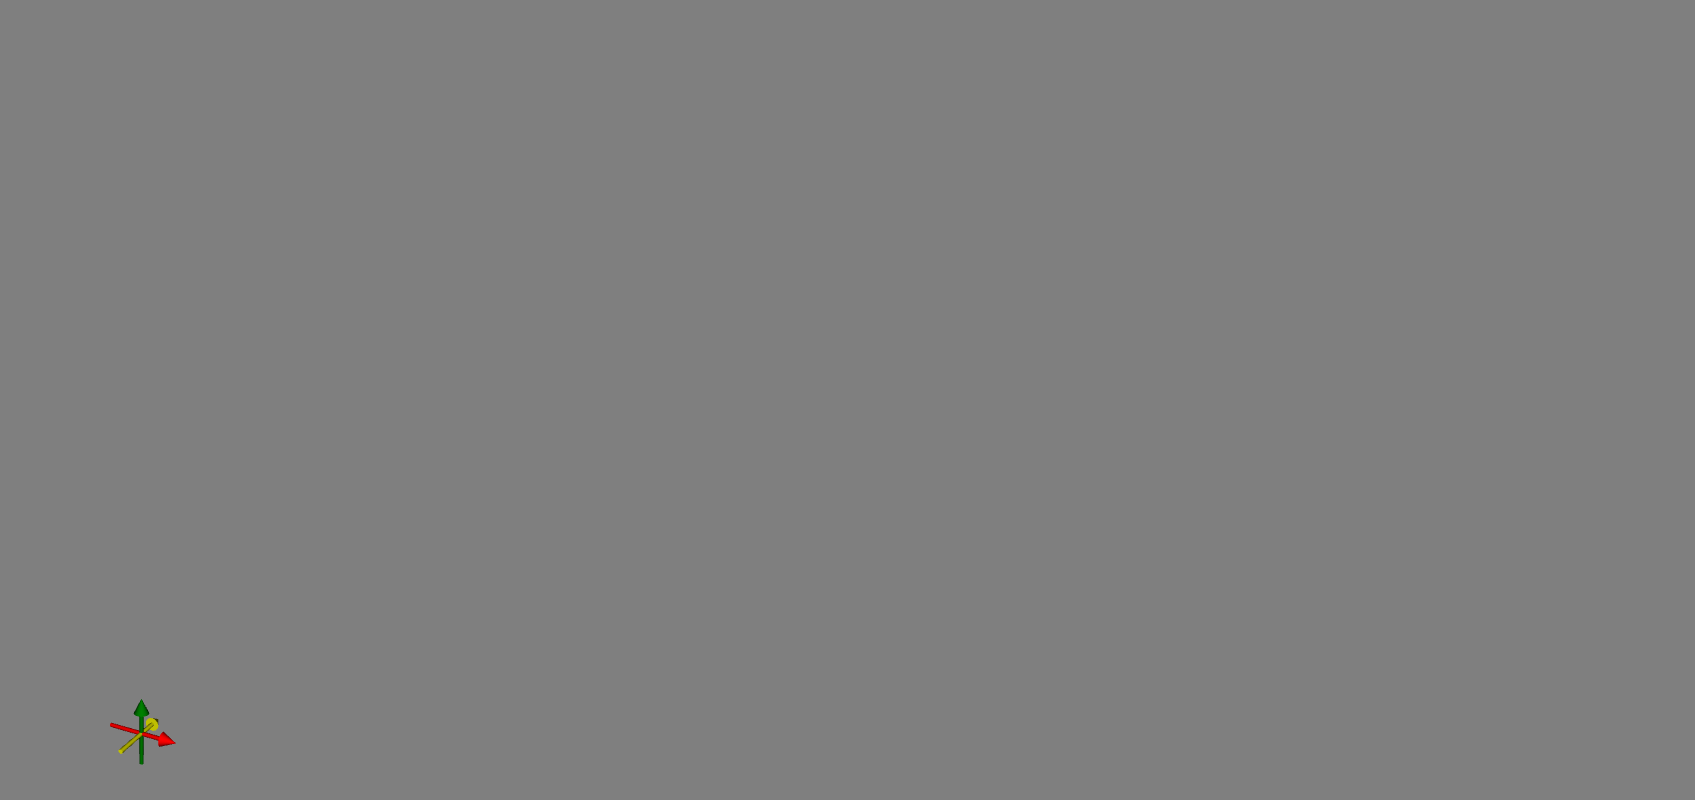
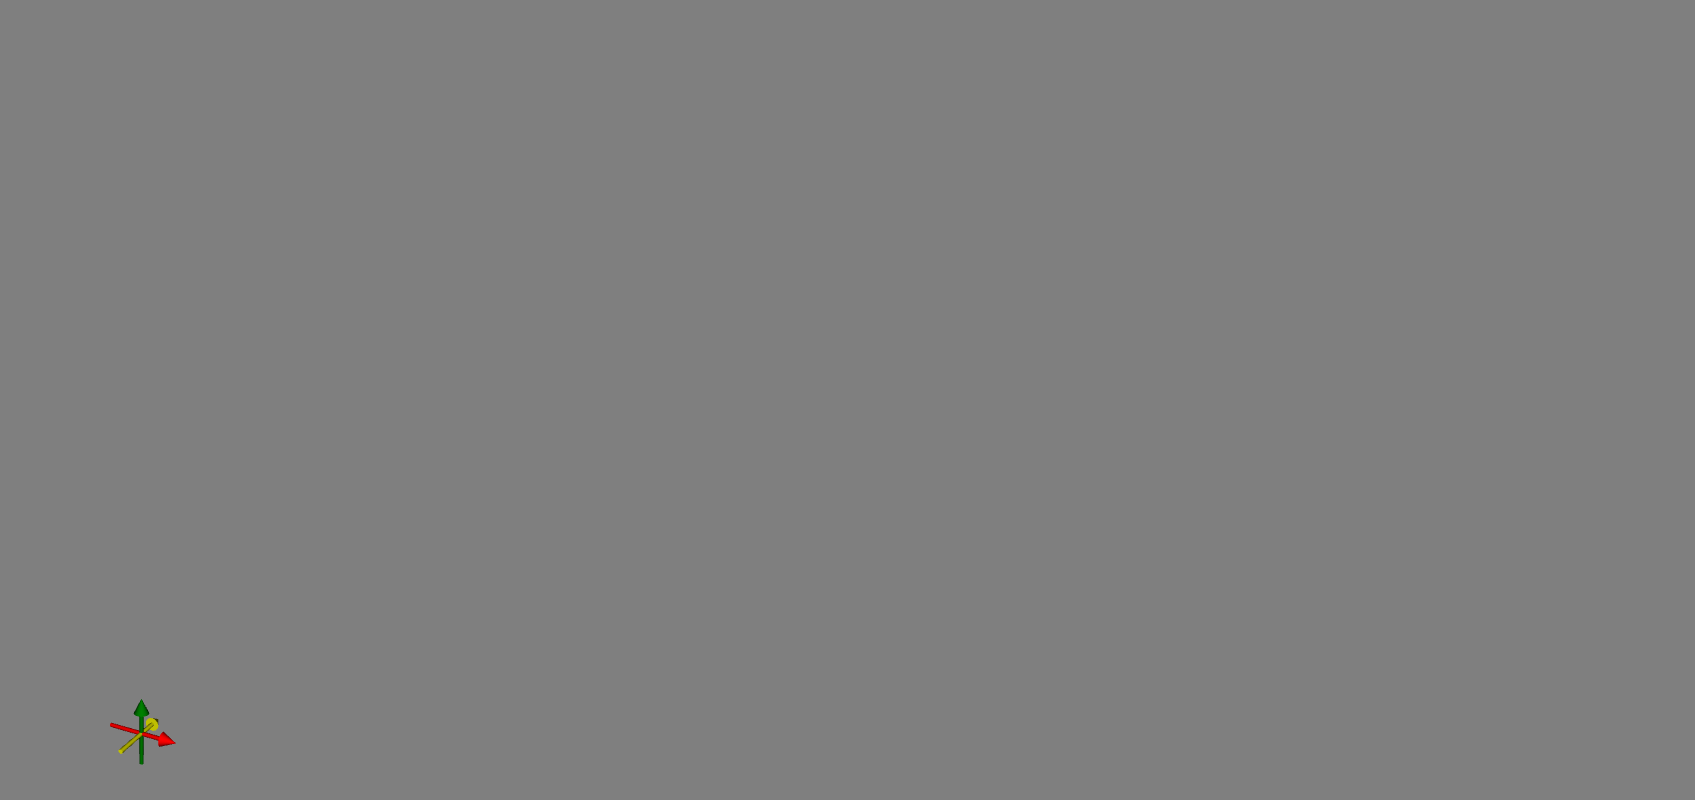

<IPython.core.display.Javascript object>

In [20]:
# Prepare the initial level set image
binary_mask = itk.imread("data/WhiteMatter.png", itk.ctype("float"))

smoothed_image = itk.smoothing_recursive_gaussian_image_filter(binary_mask)

rescaler = itk.IntensityWindowingImageFilter[FloatImageType, FloatImageType].New(
    smoothed_image
)
rescaler.SetWindowMinimum(0)
rescaler.SetWindowMaximum(255)
# Invert the input level set to have negative values inside
rescaler.SetOutputMinimum(5.0)
rescaler.SetOutputMaximum(-5.0)

rescaler.Update()
view(rescaler.GetOutput())


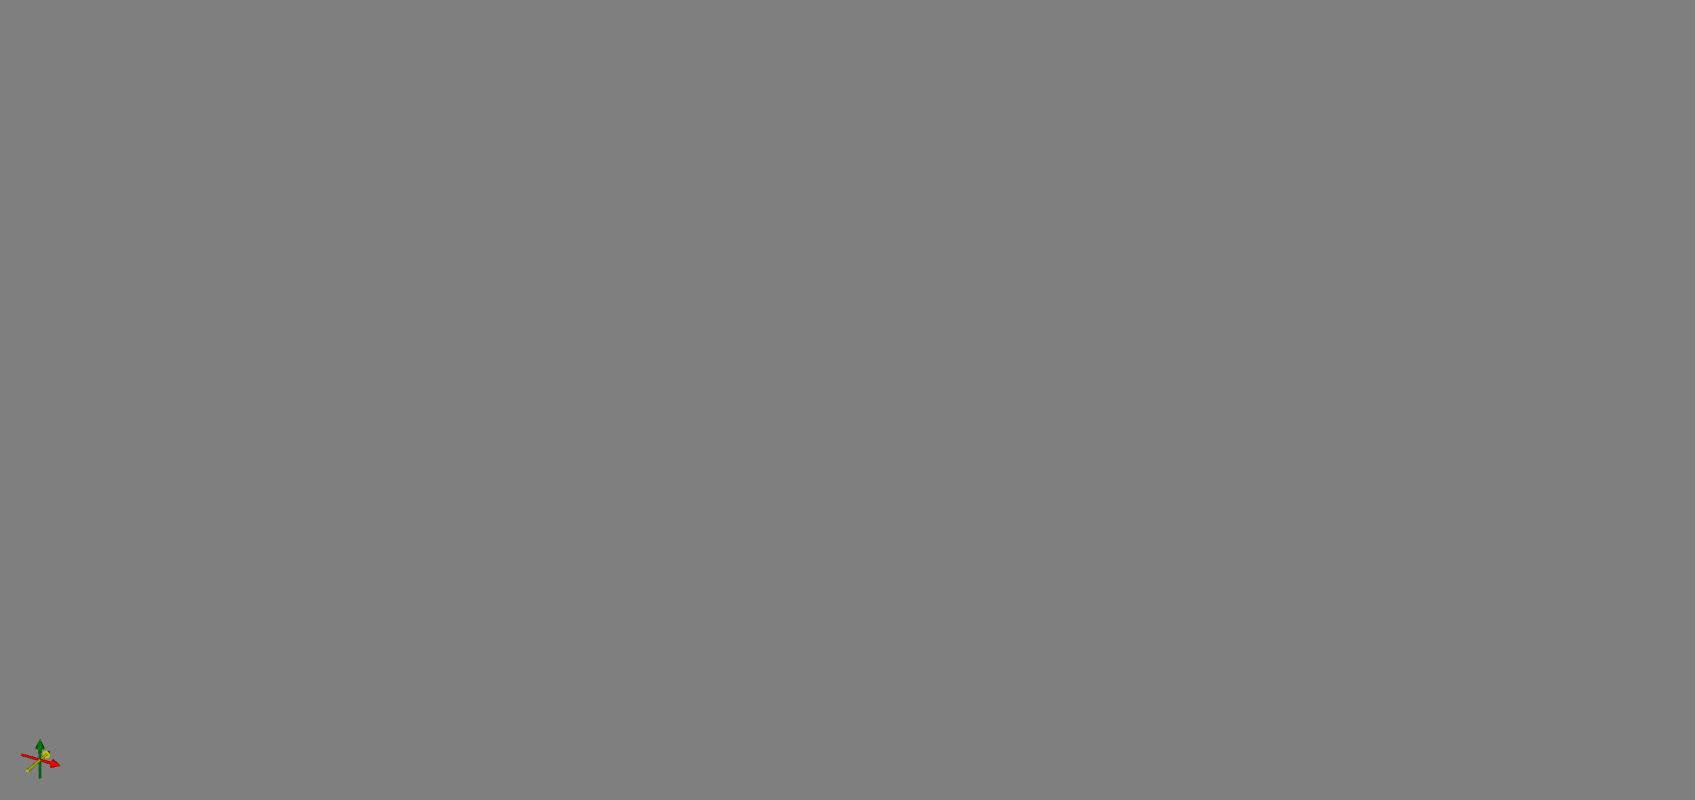
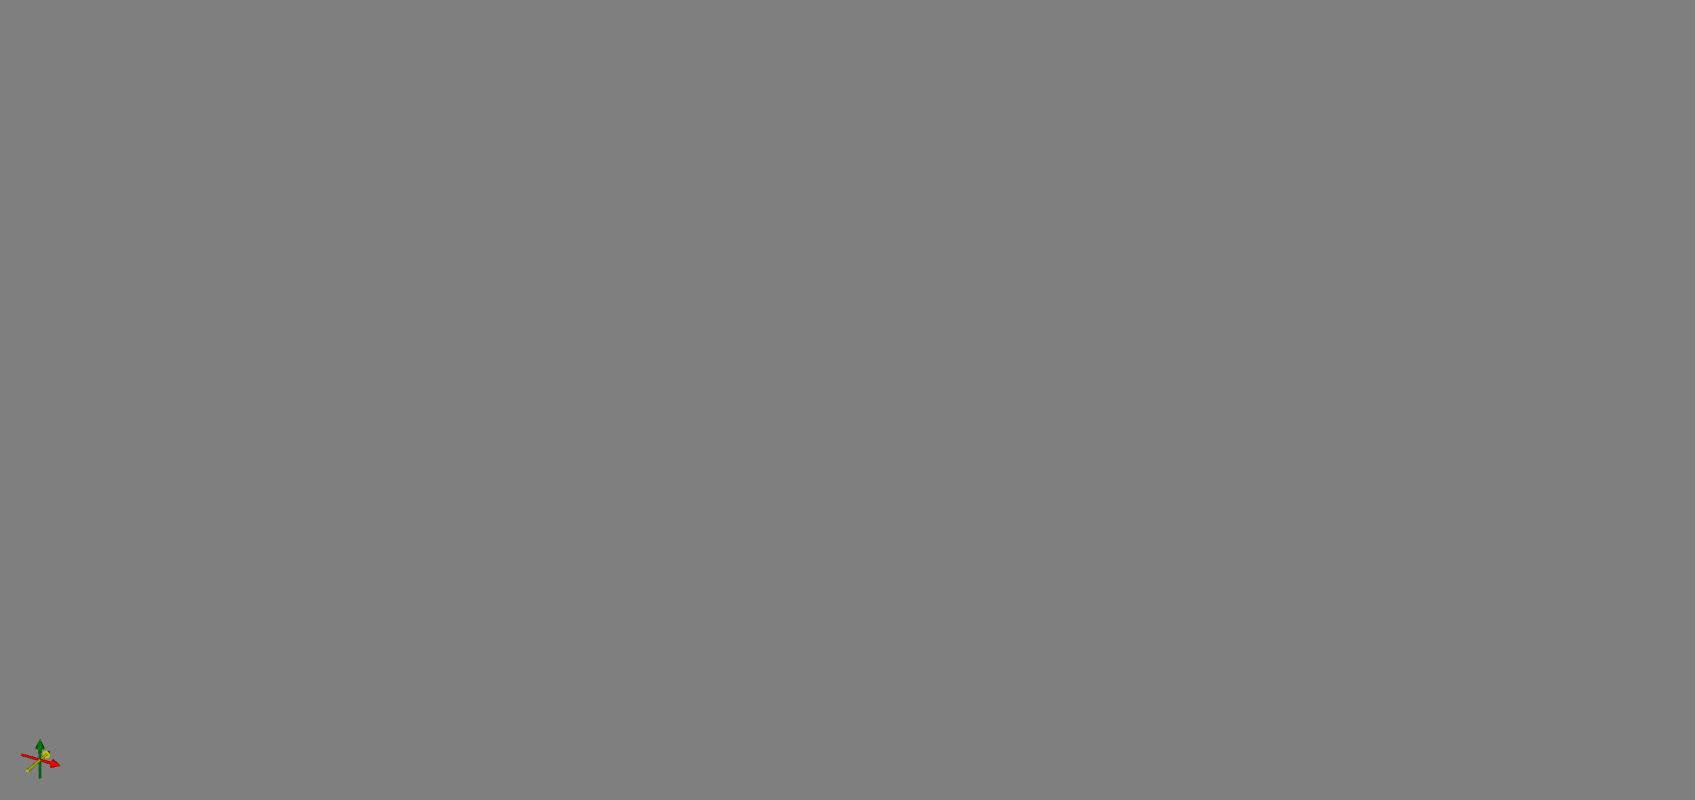

<IPython.core.display.Javascript object>

In [21]:
# Prepare the speed image
gradient = itk.gradient_magnitude_recursive_gaussian_image_filter(caster, sigma=1.0)

basin_minimum = 1
border_minimum = 5.0

alpha = -(border_minimum - basin_minimum) / 3.0
beta = (border_minimum + basin_minimum) / 2.0

sigmoid = itk.sigmoid_image_filter(
    gradient, output_minimum=0.0, output_maximum=1.0, alpha=alpha, beta=beta
)
view(sigmoid)

In [22]:
shape_detection_image = itk.shape_detection_level_set_image_filter(
    rescaler,
    feature_image=sigmoid,
    maximum_r_m_s_error=0.001,
    number_of_iterations=100,
    propagation_scaling=1.0,
    curvature_scaling=2.0,
)


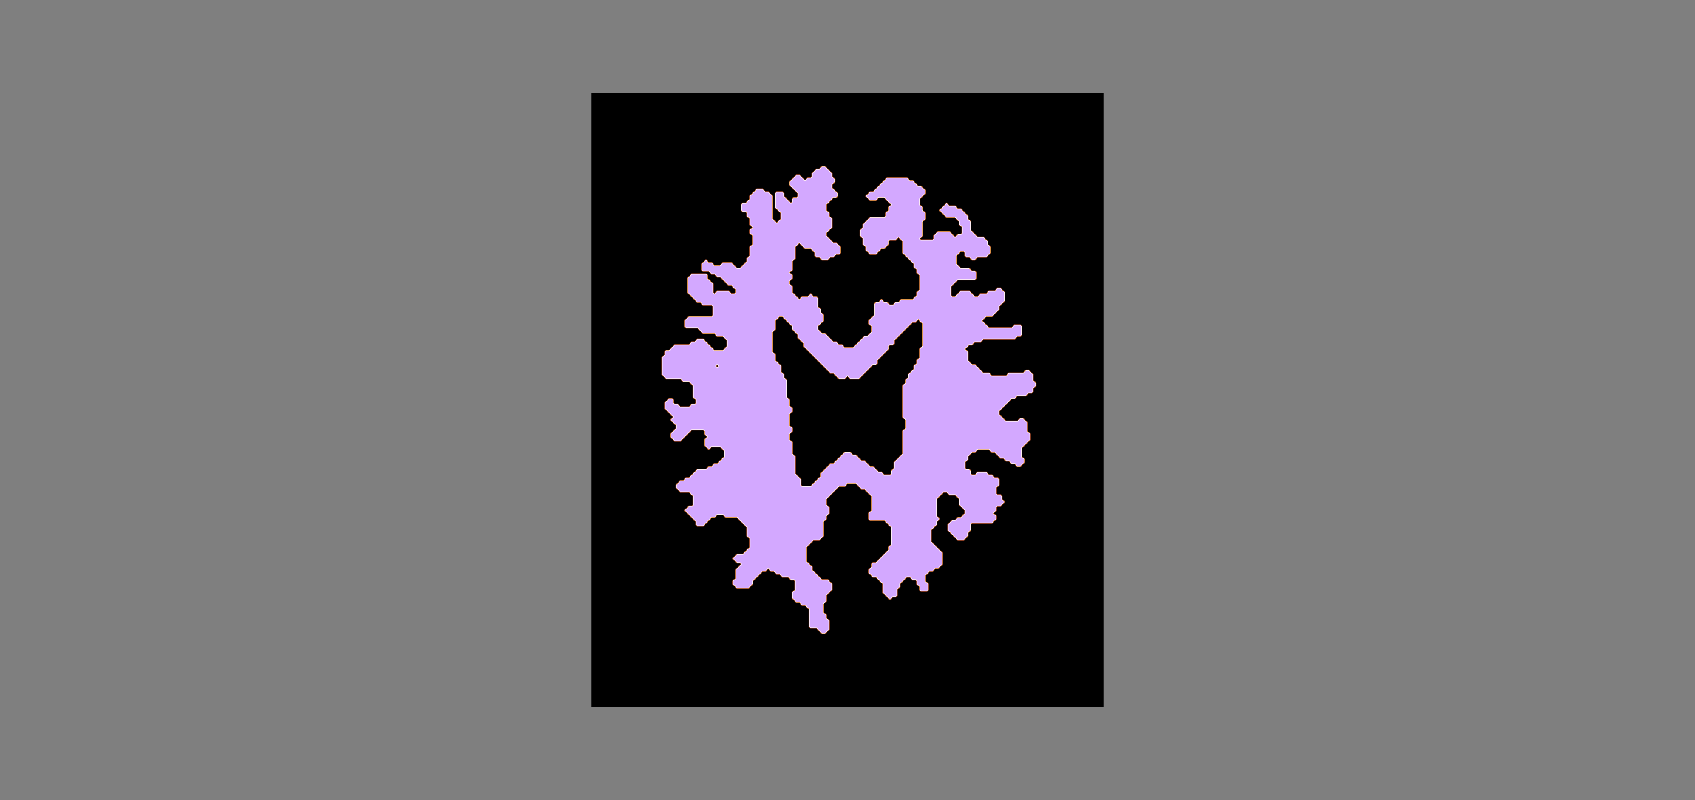
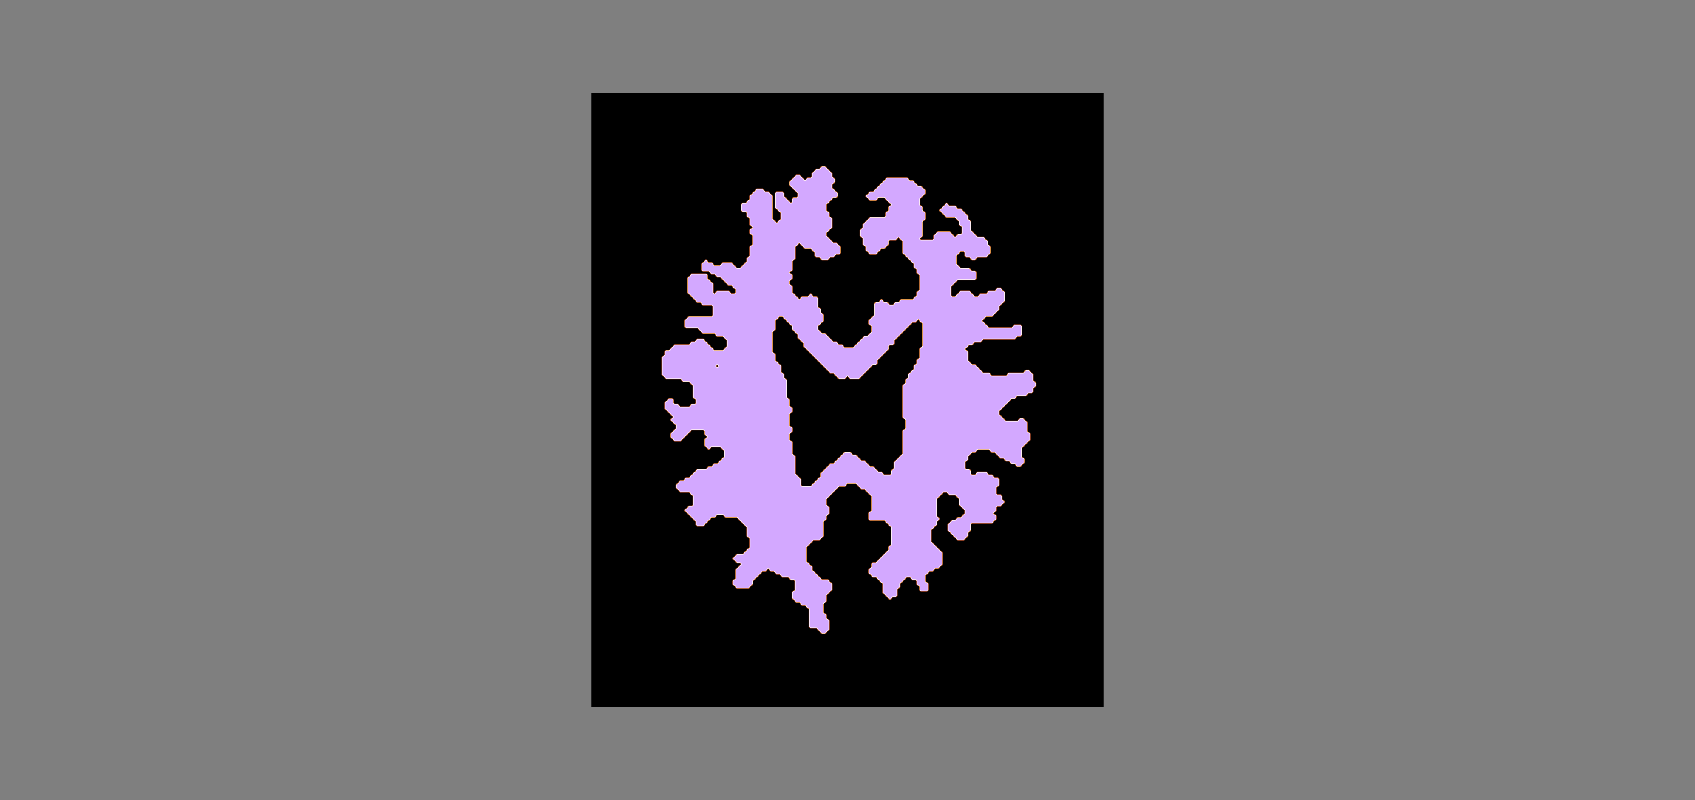

<IPython.core.display.Javascript object>

In [23]:
thresholded_image = itk.binary_threshold_image_filter(
    shape_detection_image,
    lower_threshold=-1e7,
    # Cut at the zero set
    upper_threshold=0.0,
    outside_value=0,
    inside_value=255,
)
view(thresholded_image)

## Exercises

### Exercise 1: ConnectedThresholdImageFilter vs ConfidenceConnectedmageFilter

Use [itk::ConnectedThresholdImageFilter](https://itk.org/Doxygen/html/classitk_1_1ConnectedThresholdImageFilter.html) instead of *itk::ConfidenceConnectedImageFilter*.

- Can the brain's ventricle be segmented with this filter?

**Hint:** Instead of `SetMultiplier()`, `SetInitialNeighborhoodRadius()`, and `SetNumberOfIterations()`, the new filter has methods `SetLower()` and `SetUpper()`.

In [24]:
# %load solutions/4_Segmentation_Exercise1.py

### Exercise 2: IsolatedConnectedImageFilter vs ConfidenceConnectedmageFilter

Use [itk::IsolatedConnectedImageFilter](https://itk.org/Doxygen/html/classitk_1_1IsolatedConnectedImageFilter.html) instead of *itk::ConfidenceConnectedImageFilter*.

- Can the brain's ventricle be segmented with this filter?

**Hint:** Instead of `SetMultiplier()`, `SetInitialNeighborhoodRadius()`, `SetSeed()`, and `NumberOfIterations()`, the new filter has methods `SetSeed1()`, `SetSeed2()`, `SetUpperValueLimit()`, `FindUpperThresholdOff()`.

In [25]:
# %load solutions/4_Segmentation_Exercise2.py

### Exercise 3: Level Set Curvature and Propagation Terms

Investigate the following parameters for the shape detection level set image filter.

| Min Basin | Min Boundary | Propagation Scaling | Curvature Scaling | Number of Iterations |
|-----------|--------------|---------------------|-------------------|----------------------|
| 1.0       | 5.0          | 1.0                 | 2.0               | 100                  |
| 1.0       | 5.0          | 1.0                 | 2.0               | 500                  |
| 1.0       | 5.0          | 1.0                 | 4.0               | 100                  |
| 1.0       | 20.0         | 1.0                 | 1.0               | 100                  |

- What explains the observed behavior?
- How could we stop the level set from propagating too far?

In [26]:
def explore_shape_detection_image_parameters(
    basin_minimum,
    boundary_minimum,
    propagation_scaling,
    curvature_scaling,
    number_of_iterations,
):
    input_image = itk.imread(
        "data/BrainProtonDensitySlice.png", itk.ctype("unsigned char")
    )

    # Prepare the initial level set image
    binary_mask = itk.imread("data/WhiteMatter.png", itk.ctype("float"))

    smoothed_image = itk.smoothing_recursive_gaussian_image_filter(binary_mask)

    Dimension = input_image.GetImageDimension()
    FloatImageType = itk.Image[itk.ctype("float"), Dimension]
    caster = itk.CastImageFilter[input_image, FloatImageType].New()
    caster.SetInput(input_image)

    # Prepare the speed image
    gradient = itk.gradient_magnitude_recursive_gaussian_image_filter(caster, sigma=1.0)

    alpha = -(boundary_minimum - basin_minimum) / 3.0
    beta = (boundary_minimum + basin_minimum) / 2.0

    sigmoid = itk.sigmoid_image_filter(
        gradient, output_minimum=0.0, output_maximum=1.0, alpha=alpha, beta=beta
    )

    rescaler = itk.IntensityWindowingImageFilter[FloatImageType, FloatImageType].New(
        smoothed_image
    )
    rescaler.SetWindowMinimum(0)
    rescaler.SetWindowMaximum(255)
    # Invert the input level set to have negative values inside
    rescaler.SetOutputMinimum(5.0)
    rescaler.SetOutputMaximum(-5.0)

    rescaler.Update()

    shape_detection_image = itk.shape_detection_level_set_image_filter(
        rescaler,
        feature_image=sigmoid,
        maximum_r_m_s_error=0.001,
        number_of_iterations=number_of_iterations,
        propagation_scaling=propagation_scaling,
        curvature_scaling=curvature_scaling,
    )

    thresholded_image = itk.binary_threshold_image_filter(
        shape_detection_image,
        lower_threshold=-1e7,
        # Cut at the zero set
        upper_threshold=0.0,
        outside_value=0,
        inside_value=255,
    )
    return view(thresholded_image, ui_collapsed=True)


# Uncomment and replace XX with values
# basin_minimum = XX
# boundary_minimum = XX
# propagation_scaling = XX
# curvature_scaling = XX
# number_of_iterations = XX

# explore_shape_detection_image_parameters(
#     basin_minimum,
#     boundary_minimum,
#     propagation_scaling,
#     curvature_scaling,
#     number_of_iterations,
# )

In [27]:
# %load solutions/4_Segmentation_Exercise3.py

### Enjoy ITK!